In [121]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from glob import glob
from lib import *
import random
import pandas as pd

In [48]:
path_train_img = './data/train/'
path_train_mask = './data/train_mask/'
path_test = './data/test/'

## Посмотрим на данные

Набор из 1000+ фотографий людей (селфи, портрет). Качество фотографий заметно различается.
1315 фотографий в тестовой выборке, 145 в валидационной, 100 в тестовой.
Разрешение 320х240.

Выберем случайное изображение из тренировочной выборки и посмотрим на него и его маску.

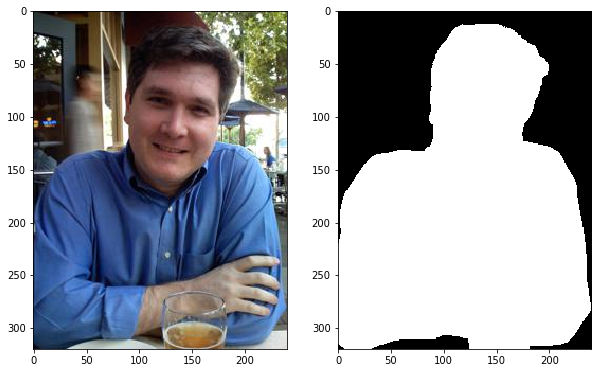

In [57]:
images = os.listdir(path_train_img)
index = np.random.choice(images).split('.')[0]
mask = cv2.imread(path_train_mask + '{}.png'.format(index))
plot_images(index, path_train_img, path_train_mask)

In [58]:
img = cv2.imread(path_train_img + '{}.jpg'.format(index))
img.shape, mask.shape

((320, 240, 3), (320, 240, 3))

In [60]:
print(np.mean(img), np.std(img))
print(np.mean(mask), np.std(mask))

99.01991753472223 60.82954724228623
172.8322265625 119.16895247876501


## Препроцессинг данных



В модель будет подаваться не весь массив изображений, а только случайно выбранные части, с заданным размером (batch_size). Размер батчей выбирается исходя из количества доступной оперативной памяти (у меня вытягивал только 12).

В тренировочной выборке 1315 изображений, что, на самом деле, очень мало. Для увеличения тренировочной выборки применяется метод аугментаций изображений - случайные повороты, сжатия, кропы. Такой метод позволяет улучшить качество модели без затрат на получение новых данных
([ссылка на репозиторий](https://github.com/albu/albumentations)). 

Зададим пути для выборок:

In [98]:
len(paths_to_imgs_test)

145

In [2]:
paths_to_imgs_train = sorted(glob('data/train/*'))
print('Неправльный путь: ', paths_to_imgs_train[5]) # В windows 10 glob() выдает недействительные пути
paths_to_imgs_train=[paths_to_imgs_train[i].replace('\\','/') for i in range(len(paths_to_imgs_train))]
print('Правильный путь:  ', paths_to_imgs_train[5])

paths_to_masks_train = sorted(glob('data/train_mask/*'))
paths_to_masks_train = [paths_to_masks_train[i].replace('\\','/') for i in range(len(paths_to_masks_train))]

paths_to_imgs_test = sorted(glob('data/valid/*'))
paths_to_imgs_test = [paths_to_imgs_test[i].replace('\\','/') for i in range(len(paths_to_imgs_test))]

paths_to_masks_test = sorted(glob('data/valid_mask/*'))
paths_to_masks_test = [paths_to_masks_test[i].replace('\\','/') for i in range(len(paths_to_masks_test))]

Неправльный путь:  data/train\1001.jpg
Правильный путь:   data/train/1001.jpg


Напишем генератор для подачи изобажений в нейросеть

In [3]:
#инитиализация аугментаций
from albumentations import (
    PadIfNeeded, HorizontalFlip, VerticalFlip, CenterCrop,    
    Crop, Compose, Transpose, RandomRotate90, ElasticTransform,
    GridDistortion, OpticalDistortion, RandomSizedCrop, OneOf, CLAHE,
    RandomBrightnessContrast, RandomGamma)


aug = Compose([    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
          ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
          GridDistortion(p=0.5),
          OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)],
           p=0.8),
    CLAHE(p=0.8),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])



Генератор выбирает случайные изображения, ресайзит, и аугментирует их в 224x224 и добавляет в тензор, который затем подается в модель

In [5]:
for x, y in generator(paths_to_imgs_train, paths_to_masks_train, 16):
    break

In [6]:
y[3].shape

(224, 224, 1)

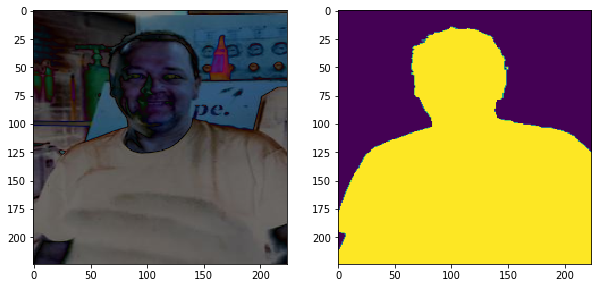

In [7]:
plot_image(x[3],y[3])

In [93]:
x.shape, y.shape

((16, 224, 224, 3), (16, 224, 224, 1))

## Модель

Используется модель Unet, за основу которой я взял аритектуру vgg16. Данный выбор обусловлен хорошим качеством архитектуры и её невысокой сложностью. 

https://arxiv.org/pdf/1505.04597.pdf

https://neurohive.io/ru/vidy-nejrosetej/vgg16-model/


In [8]:
import segmentation_models as sm #BFF
import keras
from segmentation_models import Unet
from keras.models import load_model


model = sm.Unet('vgg16', encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.f1_score],
)
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]
results = model.fit_generator(generator(paths_to_imgs_train, paths_to_masks_train, 12),
                             steps_per_epoch=100,
                             epochs=30,
                             callbacks=callbacks,
                             validation_data=generator(paths_to_imgs_test, paths_to_masks_test, 12),
                             validation_steps=50                             
                             )

Using TensorFlow backend.
W0917 05:25:57.999333 17172 deprecation_wrapper.py:119] From C:\Users\wanko\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 05:25:58.015291 17172 deprecation_wrapper.py:119] From C:\Users\wanko\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 05:25:58.019281 17172 deprecation_wrapper.py:119] From C:\Users\wanko\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0917 05:25:58.123003 17172 deprecation_wrapper.py:119] From C:\Users\wanko\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Segmentation Models: using `keras` framework.


W0917 05:25:58.455115 17172 deprecation_wrapper.py:119] From C:\Users\wanko\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0917 05:25:58.456125 17172 deprecation_wrapper.py:119] From C:\Users\wanko\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0917 05:26:00.775910 17172 deprecation_wrapper.py:119] From C:\Users\wanko\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0917 05:26:00.911548 17172 deprecation_wrapper.py:119] From C:\Users\wanko\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2239: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0917 05:2

Epoch 1/30
100/100 [==============================] - 88s 880ms/step - loss: 0.9736 - f1-score: 0.7286 - val_loss: 3.8262 - val_f1-score: 0.0822
Epoch 2/30
100/100 [==============================] - 77s 768ms/step - loss: 0.8169 - f1-score: 0.7881 - val_loss: 1.4294 - val_f1-score: 0.5937
Epoch 3/30
100/100 [==============================] - 77s 772ms/step - loss: 0.7771 - f1-score: 0.7981 - val_loss: 0.9659 - val_f1-score: 0.7161
Epoch 4/30
100/100 [==============================] - 77s 767ms/step - loss: 0.7240 - f1-score: 0.8160 - val_loss: 1.0250 - val_f1-score: 0.7341
Epoch 5/30
100/100 [==============================] - 77s 769ms/step - loss: 0.7031 - f1-score: 0.8222 - val_loss: 1.2119 - val_f1-score: 0.7113
Epoch 6/30
100/100 [==============================] - 77s 770ms/step - loss: 0.6708 - f1-score: 0.8309 - val_loss: 0.6602 - val_f1-score: 0.8506
Epoch 7/30
100/100 [==============================] - 77s 770ms/step - loss: 0.6342 - f1-score: 0.8419 - val_loss: 0.8917 - val_f1

Модель можно обучать и дальше

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Посмотим на предсказания

In [33]:
paths_to_imgs_test = sorted(glob('data/test/*'))
paths_to_imgs_test = [paths_to_imgs_test[i].replace('\\','/') for i in range(len(paths_to_imgs_test))]


for x in generator_predict(paths_to_imgs_test, len(paths_to_imgs_test)):
    break

In [34]:
pred=model.predict(x)

In [ ]:
get_rle(pred) #получим rle для каждой маски

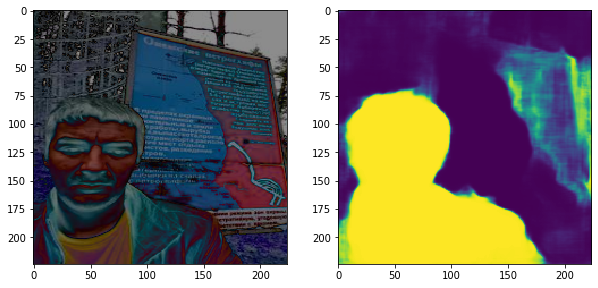

In [37]:
plot_image(x[99], pred[99])

## Оценка модели

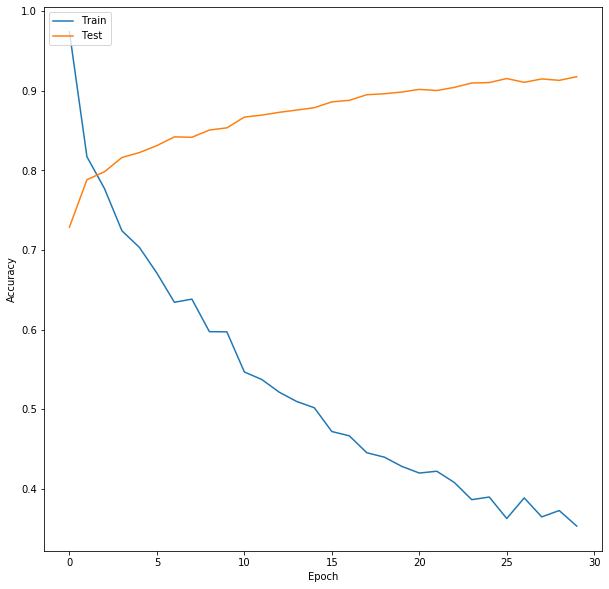

In [30]:
plot_losses(results)

In [41]:
#сохраним модель и ее веса
model.save('./models/vgg16.h5')
model.save_weights('./models/vgg16_weights.h5')

In [42]:
scores = model.evaluate_generator(generator(paths_to_imgs_train, paths_to_masks_train, 12), steps=12)

In [44]:
print("Loss: {:.5}".format(scores[0]))
print("f1-score: {:.5}".format(scores[1]))

Loss: 0.32922
iou_score: 0.92287


## Отправка результата

In [48]:
paths_to_masks_test = sorted(glob('./data/predict/*'))
paths_to_masks_test = [paths_to_masks_test[i].replace('\\','/') for i in range(len(paths_to_masks_test))]

In [81]:
#запишемданные в data/predict
for i, x in enumerate(pred):
    img = cv2.resize(np.squeeze(x*255), (240,320))
    cv2.imwrite('data/predict/{}.jpg'.format(i), img)

In [126]:
#создаем html файл с предсказаниями
paths_to_imgs = sorted(glob("data/test/*"))
paths_to_imgs = [paths_to_imgs[i].replace('\\','/') for i in range(len(paths_to_imgs))]

pred_masks = [np.array(cv2.imread(path)) for path in sorted(glob("data/predict/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example") 
#html файл создался, но картинки в нем не отображаются

In [129]:
pred.shape

(100, 224, 224, 1)

In [103]:
#загрузим шаблон в df
template = pd.read_csv('./data/pred_valid_template.csv')
template.head(5)

,id,rle_mask
0,1315,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1,1316,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
2,1317,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
3,1318,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
4,1319,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...


In [118]:
df = template
for fn, rle in enumerate(pred_rle, start=1315):
    df['rle_mask'][df['id'] == fn] = rle

C:\Users\wanko\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
df.head(5)

,id,rle_mask
0,1315,178 186 898 189 1618 189 2338 192 3055 198 377...
1,1316,14077 12 14782 45 15496 72 15586 15 16207 126 ...
2,1317,214 357 934 360 1654 360 2374 363 3091 366 381...
3,1318,193 9 247 189 967 189 1684 192 2401 195 3121 1...
4,1319,7 24 724 21 1441 15 2161 9 2881 9 3601 9 4321 ...


In [120]:
df.to_csv('./results/pred_valid.csv', index=False)